### Import lib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import pickle

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from pandarallel import pandarallel

# Initialization
pandarallel.initialize(progress_bar=True)

import warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Import phishing_site_urls dataset

In [2]:
# Read the urls database
urls_df = pd.read_csv(r'phishing_site_urls.csv')

# Rename the column
urls_df.rename(columns = {'URL':'Content'}, inplace = True)
urls_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  549346 non-null  object
 1   Label    549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [3]:
urls_df.sample(10)

,Content,Label
444353,thefreedictionary.com/Browse-wimt,good
140839,aficionado.co.za/jamiewho/2011/09/09/relish-by...,good
348243,greekgear.com/alpha-kappa-alpha-top-gifts.html,good
31139,subastaloquequieras.com/wp-includes/css/paypal/,bad
37233,www.crimepays.tv/images/voda/login.htm,bad
324793,examiner.com/family-activities-in-kansas-city/...,good
490055,qube.co.il,bad
546557,www.chcfi.com/themes/wind/views/chinese/,bad
7341,3bancaribe.uni.me/,bad
201256,irishfamine.ca/canada/political-impact,good


In [4]:
urls_df.isnull().sum()

Content    0
Label      0
dtype: int64

In [5]:
label_counter = pd.DataFrame(urls_df.Label.value_counts())

In [6]:
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

good    392924
bad     156422
Name: Label, dtype: int64


,Content,Label
0,"Subject: immigration , deferred comp question ...",good
1,Subject: fw : analyst and associate picks for ...,good
2,"Subject: 8 : 15 trade counts\n hi louise ,\n w...",good
3,Subject: deal # 413652 - meter # 9603\n the su...,good
4,Subject: gas accounting technical training cou...,good
5,Subject: re : fw : hanover\n gkh ' s drag - al...,good
6,Subject: updated : meet w / sally re : hr prog...,good
7,Subject: resume - robert goerner\n following i...,good
8,"Subject: fw : a weygandt , andrew ; glover , r...",good
9,Subject: control and echelon\n very interestin...,good


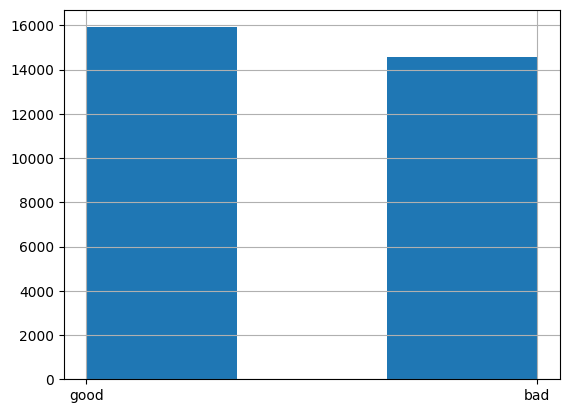

In [7]:
from os import walk
# Read the emails database
pathwalk = walk(r"enron-spam/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))
                # remove all redundant data

allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))
# storing it in a dataframe

hamPlusSpamData = allHamData + allSpamData
labels = ["good"]*len(allHamData) + ["bad"]*len(allSpamData)

emails_df = pd.DataFrame({"Content": hamPlusSpamData,
                       "Label": labels})

# get an overview of the data

emails_df.Label.hist(bins=3)
emails_df.head(10)

In [8]:
# merge database
all_df = pd.concat([urls_df, emails_df], axis=0)
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579840 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  579840 non-null  object
 1   Label    579840 non-null  object
dtypes: object(2)
memory usage: 13.3+ MB


### Preprocessing

In [9]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
all_df.Content[0]

0    nobell.it/70ffb52d079109dca5664cce6f317373782/...
0    Subject: immigration , deferred comp question ...
Name: Content, dtype: object

In [10]:
tokenizer.tokenize(urls_df.Content[0])

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [11]:
all_df['text_tokenized'] = all_df.Content.parallel_map(lambda t: tokenizer.tokenize(t))

In [12]:
all_df.sample(5)

,Content,Label,text_tokenized
335808,fao.org/docrep/field/009/ag156e/AG156E04.htm,good,"[fao, org, docrep, field, ag, e, AG, E, htm]"
394165,musclecars301.org/Pontiac+GTO/1964+Pontiac+GTO...,good,"[musclecars, org, Pontiac, GTO, Pontiac, GTO, ..."
351574,hiphopdx.com/index/interviews/id.1528/title.ri...,good,"[hiphopdx, com, index, interviews, id, title, ..."
148674,ben10.tystoybox.com/,good,"[ben, tystoybox, com]"
86267,www.sharkysoft.com/tutorials/linuxtips/floppyi...,good,"[www, sharkysoft, com, tutorials, linuxtips, f..."


In [13]:
stemmer = SnowballStemmer("english")
all_df['text_stemmed'] = all_df['text_tokenized'].parallel_map(lambda l: [stemmer.stem(word) for word in l])


In [14]:
all_df.sample(5)

,Content,Label,text_tokenized,text_stemmed
57092,www.eeaa.gov.eg/seam/,good,"[www, eeaa, gov, eg, seam]","[www, eeaa, gov, eg, seam]"
190411,freepages.genealogy.rootsweb.ancestry.com/%7En...,good,"[freepages, genealogy, rootsweb, ancestry, com...","[freepag, genealog, rootsweb, ancestri, com, e..."
448059,tngenweb.org/madisonfiles/families/arnold.htm,good,"[tngenweb, org, madisonfiles, families, arnold...","[tngenweb, org, madisonfil, famili, arnold, htm]"
125783,pollsbee.com/able/GD/,bad,"[pollsbee, com, able, GD]","[pollsbe, com, abl, gd]"
165283,dictionary.sensagent.com/université+de+montréa...,good,"[dictionary, sensagent, com, universit, de, mo...","[dictionari, sensag, com, universit, de, montr..."


In [15]:
all_df['text_sent'] = all_df['text_stemmed'].parallel_map(lambda l: ' '.join(l))

In [16]:
all_df.sample(5)

,Content,Label,text_tokenized,text_stemmed,text_sent
202339,jamessdixon.wordpress.com/,good,"[jamessdixon, wordpress, com]","[jamessdixon, wordpress, com]",jamessdixon wordpress com
149454,bitchinlifestyle.tv/Crew-Bios.html,good,"[bitchinlifestyle, tv, Crew, Bios, html]","[bitchinlifestyl, tv, crew, bio, html]",bitchinlifestyl tv crew bio html
149719,blakelyburltree.com/team.htm,good,"[blakelyburltree, com, team, htm]","[blakelyburltre, com, team, htm]",blakelyburltre com team htm
3767,habbor-sulake.cabanova.com/,bad,"[habbor, sulake, cabanova, com]","[habbor, sulak, cabanova, com]",habbor sulak cabanova com
184191,es.houstonisd.org/burbankes/,good,"[es, houstonisd, org, burbankes]","[es, houstonisd, org, burbank]",es houstonisd org burbank


### Visualization

In [17]:
bad_sites = all_df[all_df.Label == 'bad']
good_sites = all_df[all_df.Label == 'good']

In [18]:
bad_sites.head()

,Content,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [19]:
good_sites.head()

,Content,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


### Creating Model

In [20]:
cv = CountVectorizer()
feature = cv.fit_transform(all_df.text_sent)

In [21]:
feature[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [22]:
trainX, testX, trainY, testY = train_test_split(feature, all_df.Label)

In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from numpy import argmax

def build_and_test(X_tr, X_te, y_tr, y_te, class_weight=None, threshold=False):
    # Build and Plot PCA
    pca = PCA(n_components=2)
    pca.fit(X_tr.toarray())
    X_pca = pca.transform(X_tr.toarray())



In [24]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# Make undersampling to decreases the number of samples of the 
# biggest class down to the size of the smallest class

under_sampler = RandomUnderSampler(random_state=0)
trainX, trainY = under_sampler.fit_resample(trainX, trainY)
print(f"Training target statistics: {Counter(trainY)}")
print(f"Testing target statistics: {Counter(testY)}")

Training target statistics: Counter({'bad': 128351, 'good': 128351})
Testing target statistics: Counter({'good': 102305, 'bad': 42655})


In [25]:
#roc_auc_rus,fpr_rus,tpr_rus , _ = build_and_test(X_under, testX, y_under, testY)

### Logistic Regression

In [26]:
lr = LogisticRegression()
lr.fit(trainX,trainY)
lr.score(testX,testY)

0.9584850993377484

In [27]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9777835778451278
Testing Accuracy : 0.9584850993377484

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.94      0.92      0.93     43955
        Good       0.96      0.98      0.97    101005

    accuracy                           0.96    144960
   macro avg       0.95      0.95      0.95    144960
weighted avg       0.96      0.96      0.96    144960


CONFUSION MATRIX


<AxesSubplot: >

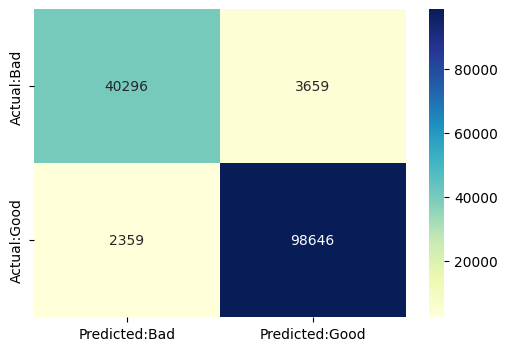

In [28]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Kfold Cross Validation to LR

In [29]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold_validation=KFold(10)

# apply cross validation to Logistic Regeression model
results=cross_val_score(lr,testX,testY,cv=kfold_validation)
print(results)
print(np.mean(results))

[0.94633002 0.94757174 0.95095199 0.95040011 0.94860651 0.94577815
 0.94577815 0.95060706 0.95067605 0.94812362]
0.9484823399558499


### Multinomial Naive Bayes

In [30]:
mnb = MultinomialNB()
mnb.fit(trainX,trainY)
mnb.score(testX,testY)

0.9475717439293598

In [31]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9696067814041184
Testing Accuracy : 0.9475717439293598

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.94      0.89      0.91     45019
        Good       0.95      0.97      0.96     99941

    accuracy                           0.95    144960
   macro avg       0.94      0.93      0.94    144960
weighted avg       0.95      0.95      0.95    144960


CONFUSION MATRIX


<AxesSubplot: >

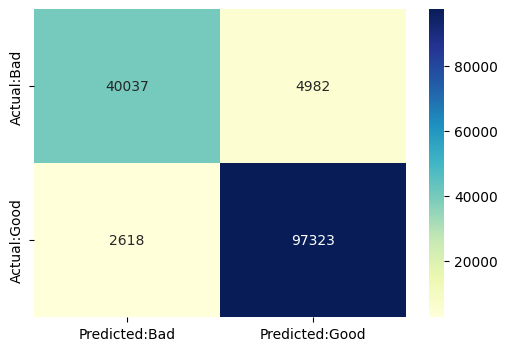

In [32]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Kfold Cross Validation to MNB

In [ ]:
kfold_validation=KFold(10)

# apply cross validation to Logistic Regeression model
results=cross_val_score(mnb,testX,testY,cv=kfold_validation)
print(results)
print(np.mean(results))

### Support Vector Machine

In [33]:
X_train, X_test, y_train, y_test = train_test_split(feature, all_df.Label, test_size=0.25, random_state=27)
under_sampler = RandomUnderSampler(random_state=27)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(testY)}")


Training target statistics: Counter({'bad': 128247, 'good': 128247})
Testing target statistics: Counter({'good': 102305, 'bad': 42655})


In [34]:
SVC_model = svm.SVC(kernel='linear')

In [35]:
SVC_model.fit(X_train, y_train)

SVC(kernel='linear')

In [36]:
SVC_prediction = SVC_model.predict(X_test)

In [37]:
print(confusion_matrix(SVC_prediction, y_test))

[[41137  2739]
 [ 1622 99462]]


### Kfold Cross Validation to SVC

In [43]:
kfold_validation=KFold(10)

# apply cross validation to Logistic Regeression model
results=cross_val_score(SVC_model,testX,testY,cv=kfold_validation)
print(results)
print(np.mean(results))

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.

### KNN_model

In [38]:
KNN_model = KNeighborsClassifier(n_neighbors=3)

KNN_model.fit(X_train, y_train)

KNN_prediction = KNN_model.predict(X_test)
print(classification_report(KNN_prediction, y_test))

              precision    recall  f1-score   support

         bad       0.99      0.52      0.68     80692
        good       0.62      0.99      0.77     64268

    accuracy                           0.73    144960
   macro avg       0.81      0.76      0.72    144960
weighted avg       0.83      0.73      0.72    144960



Logistic Regression    0.96
MultinomialNB          0.95
Name: Accuracy, dtype: float64


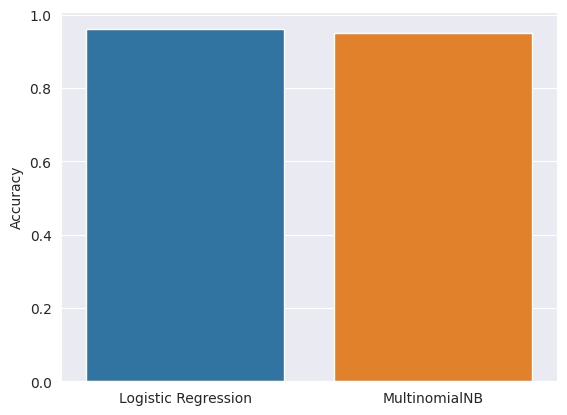

In [39]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
sns.barplot(x=acc.index,y=acc.Accuracy)
print(acc.Accuracy)

### sklearn pipeline with Logistic Regression

In [40]:
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())

In [41]:
trainX, testX, trainY, testY = train_test_split(all_df.Content, all_df.Label)
under_sampler = RandomUnderSampler(random_state=0)
trainX, trainY = under_sampler.fit_resample(trainX, trainY)
print(f"Training target statistics: {Counter(trainY)}")
print(f"Testing target statistics: {Counter(testY)}")

ValueError: Expected 2D array, got 1D array instead:
array=['celebritywonder.ugo.com/html/lorenzolamas.html'
 'ussfulton.org/history.html'
 'ovguide.com/middle-sexes-redefining-he-and-she-9202a8c04000641f8000000009635708'
 ... 'beatelement.com.au/login/dropbox/'
 'aaa.net.au/zz/hash/login.php?email=abuse@ingenieriaintegral.com'
 'sportsmemorabilia.com/player/Rich_Nye'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
pipeline_ls.fit(trainX,trainY)

In [ ]:
pipeline_ls.score(testX,testY) 

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
pickle.dump(pipeline_ls,open('phishing_LR.pkl','wb'))
loaded_model = pickle.load(open('phishing_LR.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['whitehouse.gov/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing_LR.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

# Test SVC model

In [ ]:
# Support Vector Machine
from sklearn import svm
SVC_model = svm.SVC(kernel='linear')
SVC_model.fit(X_train, y_train)
SVC_prediction = SVC_model.predict(X_test)
# But Confusion Matrix and Classification Report give more details about performance
print(confusion_matrix(SVC_prediction, y_test))
# Accuracy score is the simplest way to evaluate
print(accuracy_score(SVC_prediction, y_test))

# sklearn pipeline using SVC
from sklearn.pipeline import make_pipeline
pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), svm.SVC(kernel='linear'))
X_train, X_test, y_train, y_test = train_test_split(all_df.Content, all_df.Label)
under_sampler = RandomUnderSampler(random_state=0)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)
pipeline_ls.fit(X_train,y_train)
pipeline_ls.score(X_test, y_test)

print('Training Accuracy :',pipeline_ls.score(X_train,y_train))
print('Testing Accuracy :',pipeline_ls.score(X_test,y_test))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(X_test), y_test),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(X_test), y_test,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

import pickle
pickle.dump(pipeline_ls,open('phishing_SVC.pkl','wb'))
loaded_model = pickle.load(open('phishing_SVC.pkl', 'rb'))
result = loaded_model.score(X_test,y_test)
print(result)

In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['whitehouse.gov','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing_SVC.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)